AIT-526, DL1, Spring 2024
Final Project - Team 6
Hannah Le, Theo Vu, Roberto Diaz, and Keith Maly
Due: April 12, 2024

Purpose: To extend the work of Semeval 2020 (Task 7) by ascertaining the ability of large language models to estimate funniness via zero-shot classification.

Code Overview // Steps in the psuedo code
1. import needed libraries (pandas, pipeline, re)
2. import the data into a dataframe
  - clean data...need to remove quotes apostrophes from headlines
3. declare the model to be used in the pipe
4. develop a loop
  - created the funny versions of the headlines
    - insert the replacement words into the sentence
    - regex replace the word inside the <tag/>
  - do this again for the second edit
  - zero-shot classifications
    - For each of the two edited headline into the pipe, perform zero-shot classification
    - the results of the each pipe are returned as a dictionary object - capture the results of the pipe in temp variable
    - extract the scores from the temp variable, which are a list; store in another temp variable
    - compute each temporary funniness score as a weighted average of that second temp variable; log these features in the table
  - compare the two funniness scores, assign the following classification labels
    - 1: LLM fun_score (edited headline 1) > (edited headline 2)
    - 2: LLM fun_score (edited headline 1) < (edited headline 2)
    - 0: LLM fun_score (edited headline 1) = (edited headline 2)
6. compare the LLM classification labels to those from Semeval Task
  - to properly assess, we have to prepare a 3x3 multi-class classification and then compute precision and recall by class

In [ ]:
# establishing connection to huggingface to access models for zero shot
#!pip install huggingface-hub
from google.colab import userdata
hf_token = userdata.get('HF_TOKEN')
from huggingface_hub import notebook_login
notebook_login()

In [2]:
# makes my g-drive accessible to google colab
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Colab Notebooks'
!ls

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks
'AIT-256_DL1_FProj_T6_for Alphaeus.ipynb'     output_4-12_bart.csv
 AIT_256_DL1_FProj_T6_v3.ipynb		      output_4-12_deberta.csv
 AIT-526_DL1_FProj_T6_draft.ipynb	      output_4-2_bert.csv
'AIT526, DL1, Lab2, Exercise4 (MALY).ipynb'   output_4-2.csv
 AIT-526-DL1-Lab3-Maly.ipynb		      output_4-2_deberta.csv
 AIT526_DL1_Lab4_Maly.ipynb		      output_4-2.gsheet
 AIT-526_Lab1_MALY.ipynb		      output_4-8.csv
'AIT-526 Lab2 Exercise 1,2,3 Maly.ipynb'      output.csv
 AIT-526_POS_Tagging.ipynb		      output_rawscore1.csv
'AIT-526 Regex.ipynb'			      output_rawscore2.csv
 American-English.tsv			      rawscore_bart.csv
 auto_train_test.csv			      rawscore_deberta.csv
 British-English.tsv			      rawscore_diff.csv
 comb_raw_scores.csv			      sentimentdataset.csv
'Copy of AIT_256_DL1_FProj_T6_v2.ipynb'       T6_test.csv
 gpt-zero-shot.csv			      T6_train.csv
 gpt-zero-shot.ipynb			      test.csv
 output1.csv				      train.csv

In [2]:
# This setting forces the output of an executed cell to wrap
# https://stackoverflow.com/questions/58890109/line-wrapping-in-collaboratory-google-results
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
# Step 1. import the training dataset
# reference: https://www.w3schools.com/python/pandas/pandas_csv.asp

import pandas as pd
'''comment: two options for data import are available, because zero-shot classification
could not be completed at once. 'train.csv' is the data from training data
set from semeval 2020, task 7, subtask 2. 'output.csv is the working file that
was stored offline intermittently, for which steps 2 and 3 are completed
while working on step 4. please comment out the file the viewer does not want
to import'''

#df = pd.read_csv('test.csv')
df = pd.read_csv('output_4-2.csv')

In [ ]:
# Step 2. Data Cleaning
# goal: remove apostrophe's and quotation marks that might otherwise screw up string processing
# references
# https://www.geeksforgeeks.org/different-ways-to-iterate-over-rows-in-pandas-dataframe/
#

punct = ['’','“','”','\"','\'']

# use one external loop to clean the original1 and original2 features in the dataframe
for i in df.index:
    # temp items
    list_item1 = ''
    list_item2 = ''

    # transfer strings from cells for review
    review1 = df ['original1'][i]
    review2 = df ['original2'][i]

    #iterate over the first string
    for w in review1:
        if w in punct:
            continue
        else:
            list_item1 = list_item1 + w
    df['original1'][i] = list_item1

    #iterate over the second string
    for x in review2:
        if x in punct:
            continue
        else:
            list_item2 = list_item2 + x
    df['original2'][i] = list_item2

<ipython-input-6-f2ffaed83cd7>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original1'][i] = list_item1
<ipython-input-6-f2ffaed83cd7>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['original2'][i] = list_item2


In [ ]:
# Step 3. Regex Replace of the <tagged/> word in original1 and original2
import re
# reference: https://builtin.com/data-science/pandas-add-column
#del df['edited1']
#del df['edited2']
df.insert(10,'edited1','')
df.insert(11,'edited2','')

# create 2 new features, edited1 and edited2, to store the edited headlines
for i in df.index:
  orig1 = df['original1'][i]
  orig2 = df['original2'][i]
  rep_word1 = df['edit1'][i]
  rep_word2 = df['edit2'][i]
  e1 = re.sub(r'<[A-Za-z]+/>', rep_word1, orig1)
  e2 = re.sub(r'<[A-Za-z]+/>', rep_word2, orig2)
  df['edited1'][i] = e1
  df['edited2'][i] = e2

<ipython-input-7-a481413c220e>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['edited1'][i] = e1
<ipython-input-7-a481413c220e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['edited2'][i] = e2


In [ ]:
# Step 4. Load Model.
from transformers import pipeline

#pipe = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
pipe = pipeline("zero-shot-classification", model="sileod/deberta-v3-base-tasksource-nli")

config.json:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

In [ ]:
# Step 4. Complete the zero-shot classification
# reference: https://huggingface.co/tasks/zero-shot-classification
# reference: https://www.educative.io/answers/how-to-delete-a-column-in-pandas
# reference: https://huggingface.co/facebook/bart-large-mnli

direction = 'Rate the funniness of the following input text: '

# if the code was run before, delete the columns
del df['fun_score1']
del df['fun_score2']
del df['LLM_class']

# create new columns and populate with bogus features that cannot be real
df.insert(12,'fun_score1',-1)
df.insert(13,'fun_score2',-1)
df.insert(14,'LLM_class', -999)

raw_score1 = []
raw_score2 = []

labels=['funny','moderately funny','slightly funny','not funny']

for i in df.index:
  print(i)
  # get edited headlines out of dataframe
  t1 = direction + (df['edited1'][i])
  t2 = direction + (df['edited2'][i])

  # perform zero-shot classification
  a1 = pipe(t1, labels,)
  a2 = pipe(t2, labels,)

  # extract the labels and score values from the dictionary object that
  # the classification returns
  l1 = a1['labels']
  l2 = a2['labels']
  s1 = a1['scores']
  s2 = a2['scores']
  w1 = [0, 0, 0, 0]
  w2 = [0, 0, 0, 0]
  rs1 = [0, 0, 0, 0]
  rs2 = [0, 0, 0, 0]

  # generate a tailored weight list based on the order of the labels
  for k in range (0,4):
    if l1[k] == 'funny':
      w1[k] = 3
      continue
    elif l1[k] == 'moderately funny':
      w1[k] = 2
      continue
    elif l1[k] == 'slightly funny':
      w1[k] = 1
      continue
    else:
      w1[k] = 0

  for k in range (0,4):
    if l2[k] == 'funny':
      w2[k] = 3
      continue
    elif l2[k] == 'moderately funny':
      w2[k] = 2
      continue
    elif l2[k] == 'slightly funny':
      w2[k] = 1
      continue
    else:
      w2[k] = 0

  # this script reorders the weights from not funny(0) to funny(3)
  for c in range(0,4):
   p = w1[c]
   rs1[p] = s1[c]

  for c in range(0,4):
   p = w2[c]
   rs2[p] = s2[c]

  raw_score1.append(rs1)
  raw_score2.append(rs2)

  # compute weighted average of the score for that headline
  fscore1 = 0
  fscore2 = 0

  for r in range(0,4):
    fscore1 += (s1[r] * w1[r])
    fscore2 += (s2[r] * w2[r])

  # round score to the nearest hundreth
  fscore1 = round(fscore1, 2)
  fscore2 = round(fscore2, 2)

  # store the computed funniness score
  df.at[i, 'fun_score1'] = fscore1
  df.at[i, 'fun_score2'] = fscore2

  LLM_c = -999

  # compare scores and assign labels
  if fscore1 > fscore2:
    LLM_c = 1
  elif fscore1 < fscore2:
    LLM_c = 2
  else:
    LLM_c = 0

  # store the classification for later comparison
  df.at[i, 'LLM_class'] = LLM_c


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [4]:
# (Temporary) Step 4.1. Temporary I/O Step used to save off the intermediate csvs
# while running the classification process.

# reference: https://towardsdatascience.com/how-to-export-pandas-dataframe-to-csv-2038e43d9c03

import pandas as pd
df = pd.read_csv('gpt-zero-shot.csv')
#df_fs1 = pd.DataFrame(raw_score1)
#df_fs2 = pd.DataFrame(raw_score2)

#df_fs1.to_csv('output_rawscore1.csv')
#df_fs2.to_csv('output_rawscore2.csv')

#df.to_csv('output_4-12_bart.csv')
#df.to_csv('output_4-12_deberta.csv')

In [5]:
# Step 5. Comparison of expected and actual classification values
'''reference: https://www.evidentlyai.com/classification-metrics/confusion-matrix
reference: https://www.evidentlyai.com/classification-metrics/multi-class-metrics

By convention, actual values are along the vertical axis of the classification
matrix and the expected values are along the horizontal axis. the position
of each variable below in the 3x3 matrix read left-to-right, top-to-bottom
are shown in parenthesis.'''

# define variables
Tp00 = 0 # true positive when both expected and predicted were zero  (1)
Tp11 = 0 # true positive when both expected and predicted were one   (2)
Tp22 = 0 # true positive when both expected and predicted were two   (3)
Fp10 = 0 # false positive when actual was one and predicted was zero (4)
Fp20 = 0 # false positive when actual was two and predicted was zero (5)
Fp21 = 0 # false positive when actual was two and predicted was one  (6)
Fn01 = 0 # false positive when actual was zero and predicted was one (7)
Fn02 = 0 # false positive when actual was zero and predicted was two (8)
Fn12 = 0 # false positive when actual was one and predicted was two  (9)

# iterate through the data frame and compare the 'label' and 'LLM_class'
# features. there are probably more elegant ways to count with lower compute
# cost, but this is clear and unambiguous to the 'citizen developer'

for i in df.index:
  pred = df['comparison_label'][i]
  #pred = df['LLM_class'][i]
  act = df['label'][i]
  if act == 0 and pred == 0:
    Tp00 += 1
    continue
  if act == 1 and pred == 1:
    Tp11 += 1
    continue
  if act == 2 and pred == 2:
    Tp22 += 1
    continue
  if act == 1 and pred == 0:
    Fp10 += 1
    continue
  if act == 2 and pred == 0:
    Fp20 += 1
    continue
  if act == 2 and pred == 1:
    Fp21 += 1
    continue
  if act == 0 and pred == 1:
    Fn01 += 1
    continue
  if act == 0 and pred == 2:
    Fn02 += 1
    continue
  if act == 1 and pred == 2:
    Fn12 += 1
    continue

print('Multi-Class Confusion Matrix')
print('Expected Horizontal; Actual Vertical')
print(Tp00,'\t',Fn01,'\t',Fn02)
print(Fp10,'\t',Tp11,'\t',Fn12)
print(Fp20,'\t',Fp21,'\t',Tp22)


Multi-Class Confusion Matrix
Expected Horizontal; Actual Vertical
378 	 301 	 318
1596 	 1414 	 1181
1564 	 1211 	 1398


In [6]:
# Step 7. Computing Accuracy, Classification and Recall

total = len(df)
correct = Tp00 + Tp11 + Tp22
accuracy = correct / total
print('Accuracy:', round(accuracy,2))

precision_0 = Tp00/(Tp00 + Fp10 + Fp20)
print('Precision for Class 0:', round(precision_0,2))

precision_1 = Tp11/(Tp11+ Fn01 + Fp21)
print('Precision for Class 1:', round(precision_1,2))

precision_2 = Tp22/(Tp22 + Fn02 + Fn12)
print('Precision for Class 2:', round(precision_2,2))

recall_0 = Tp00/(Tp00 + Fn01 + Fn02)
print('Recall for Class 0:', round(recall_0,2))

recall_1 = Tp11/(Tp11 + Fp10 + Fn12)
print('Recall for Class 1:', round(recall_1,2))

recall_2 = Tp22/(Tp22 + Fp20 + Fp21)
print('Recall for Class 2:', round(recall_2,2))

F_score_0 = 2*((precision_0*recall_0)/(precision_0+recall_0))
print('F-score for Class 0:', round(F_score_0,2))

F_score_1 = 2*((precision_1*recall_1)/(precision_1+recall_1))
print('F-score for Class 1:', round(F_score_1,2))

F_score_2 = 2*((precision_2*recall_2)/(precision_2+recall_2))
print('F-score for Class 2:', round(F_score_2,2))

Accuracy: 0.34
Precision for Class 0: 0.11
Precision for Class 1: 0.48
Precision for Class 2: 0.48
Recall for Class 0: 0.38
Recall for Class 1: 0.34
Recall for Class 2: 0.34
F-score for Class 0: 0.17
F-score for Class 1: 0.4
F-score for Class 2: 0.4


In [ ]:
!pip install matplotlib

In [7]:
# Step 8. Stacked histograms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#import data

#deberta_rawscore = pd.read_csv('rawscore_deberta.csv')
#bart_rawscore = pd.read_csv('rawscore_bart.csv')
#rawscore_diff = pd.read_csv('rawscore_diff.csv')
comb_rawscore = pd.read_csv('comb_raw_scores_1.csv')

#deberta_rawscore = round(deberta_rawscore, 2)
#bart_rawscore = round(bart_rawscore, 2)

In [ ]:
n_bins=100
colors = ['blue', 'orange', 'green', 'red']
plt.hist(bart_rawscore, n_bins, range = (0,1), density= False
         , histtype='step', stacked=True, label=['Not Funny (0)'
         , 'Slightly Funny (1)', 'Moderately Funny (2)', 'Funny (3)'])
plt.legend(loc="upper right")
plt.title('Bart Model Raw Scores')
plt.show()

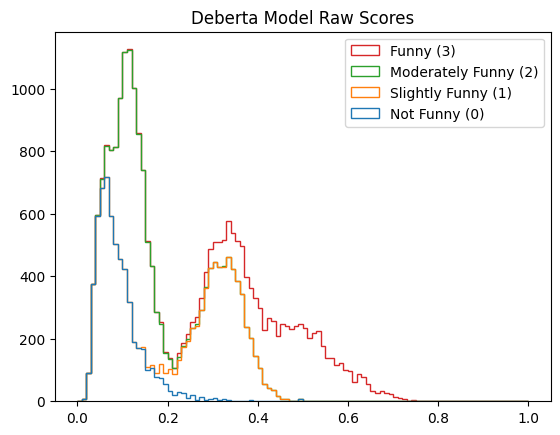

In [ ]:
n_bins=100
colors = ['blue', 'orange', 'green', 'red']
plt.hist(deberta_rawscore, n_bins, range = (0,1), density= False
         , histtype='step', stacked=True, label=['Not Funny (0)'
         , 'Slightly Funny (1)', 'Moderately Funny (2)', 'Funny (3)'])
plt.legend(loc="upper right")
plt.title('Deberta Model Raw Scores')
plt.show()

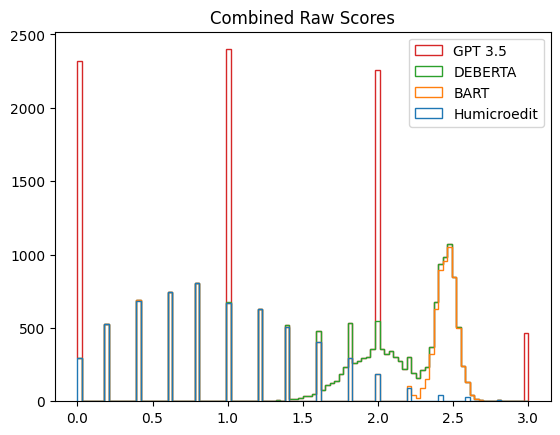

In [9]:
n_bins=100
colors = ['blue', 'orange', 'green','red']
plt.hist(comb_rawscore, n_bins, range = (0,3), density= False
         , histtype='step', stacked=True, label=['Humicroedit'
         , 'BART', 'DEBERTA','GPT 3.5'])
plt.legend(loc="upper right")
plt.title('Combined Raw Scores')
plt.show()

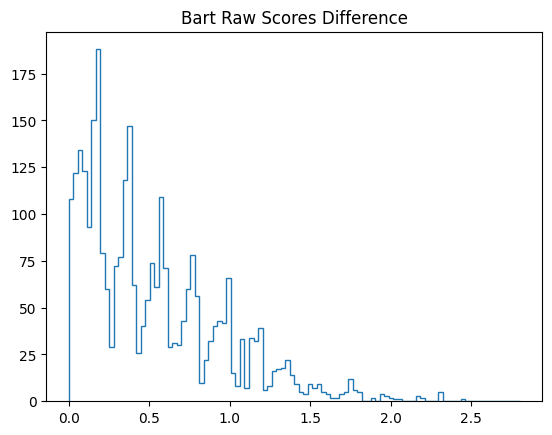

In [ ]:
n_bins=100
plt.hist(rawscore_diff['bart'], n_bins, range = (0,2.8), density= False
         , histtype='step')
plt.title('Bart Raw Scores Difference')
plt.show()